In [211]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [212]:
# load preprocess datasets
path_to_pro = '../../data/processed/'
path_to_final = '../../data/final/'

wine_data = pd.read_csv(
    os.path.join(path_to_final, "wine_final.csv")
)

eto_data = pd.read_csv(
    os.path.join(path_to_final, "eto_final.csv")
)

meteo_data = pd.read_csv(
    os.path.join(path_to_pro, "meteo_pro.csv")
)

In [213]:
wine_data.columns

Index(['campana', 'id_finca', 'id_zona', 'id_estacion', 'altitud', 'variedad',
       'modo', 'tipo', 'color', 'superficie', 'produccion',
       'sup_tot_camp_finca', 'superficie_total', 'n_var_camp_finca',
       'prod_shift_1', 'prod_shift_2', 'prod_var_shift_1', 'prod_var_shift_2',
       'prod_finca_shift_1', 'prod_finca_shift_2',
       'prod_he_var_modo_mean_shift_1', 'prod_he_var_modo_std_shift_1'],
      dtype='object')

In [216]:
# me quedo con los snow de invierno y los precip totales

# eto_data.filter(like='Temp')


In [217]:
# eto_cols = [
#     'TotalSnowMonth1','TotalSnowMonth2', 'TotalPrecipMonth1',
#     'TotalPrecipMonth2', 'TotalPrecipMonth3', 'TotalPrecipMonth4',
#     'TotalPrecipMonth5', 'TotalPrecipMonth6', 'GustDayMaxMonth',
#     'GustDaySumMonth', 'UVIndexSummerSum', 'UVIndexWinterSum',
#     'UVIndexSummerAvg', 'UVIndexWinterAvg', 'WindSpeedSum'
# ]

# eto_data = pd.concat([
#     eto_data[['year', 'ID_ESTACION']],
#     eto_data[eto_cols],
# ],axis=1)
# eto_data


In [218]:
# eto_data.columns

In [198]:
# me quedo con los max de verano y los min de invierno

# meteo_data = pd.concat([
#     meteo_data[['year', 'ID_ESTACION']],
#     meteo_data[['max_12_to_16_temp_month_4','max_12_to_16_temp_month_5', 'max_12_to_16_temp_month_6']],
#     meteo_data[['min_1_to_5_temp_month_1', 'min_1_to_5_temp_month_2','min_1_to_5_temp_month_3']]
# ],axis=1)



In [219]:
# meteo_data.columns

In [220]:
# join datasets
eto_data['year'] = eto_data.year%2000
meteo_data['year'] = meteo_data.year%2000

In [221]:
meteo_full = eto_data.merge(
    meteo_data,
    left_on=['ID_ESTACION','year'],
    right_on=['ID_ESTACION','year'],
)

In [222]:
data_full = wine_data.merge(
    meteo_full,
    left_on = ["id_estacion","campana"],
    right_on = ['ID_ESTACION',"year"],
    how='left',
).drop(columns=['ID_ESTACION',"year"])

In [223]:
for col in eto_data.columns[2:].to_list() + meteo_data.columns[2:].to_list():
    data_full[col] = data_full.groupby(['id_estacion'])[col].transform(lambda x: x.fillna(x.mean()))


In [224]:
for col in eto_data.columns[2:].to_list() + meteo_data.columns[2:].to_list():
    data_full[col] = data_full[col].transform(lambda x: x.fillna(x.mean()))


In [225]:
data_test = data_full[data_full['campana']==22]
data = data_full[data_full['campana']<22] 

In [226]:
# final data
data.to_csv('../../data/final/train.csv', index=False)
data_test.to_csv('../../data/final/test.csv', index=False)

In [227]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, IsolationForest
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import category_encoders as ce
from xgboost import XGBRegressor
from typing import List, Tuple
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import GroupKFold, KFold
from sklearn.base import clone
import catboost as cb
from sklearn.decomposition import PCA
from sklearn.model_selection._split import _BaseKFold
from sklearn.utils.validation import _num_samples
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.metrics import make_scorer
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV

seed = 42

def rmse_score(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse_score,greater_is_better=False)

def eval_model(m, X, y, train_test_idx:List[Tuple[pd.Series,pd.Series]]):
    res = {
        "rmse":[],
        "mape":[],
    }
    for idxs in train_test_idx:
        m_ = clone(m)
        train_idx, test_idx = idxs[0], idxs[1]
        X_train, X_test, y_train, y_test = X[train_idx], X[test_idx], y[train_idx], y[test_idx]
        m_.fit(X_train, y_train)
        y_pred = m_.predict(X_test)
        mape = mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred)
        rmse = rmse_score(y_true=y_test, y_pred=y_pred)
        res['mape'].append(mape)
        res['rmse'].append(rmse)
    return res



class YearKFold(_BaseKFold):
    def __init__(self, test_idxs):
        self.test_idxs = test_idxs
        self.n_splits = len(test_idxs)

    def _iter_test_indices(self, X:pd.DataFrame, y=None, groups=None):
        for idx in self.test_idxs:
            yield idx


from malbecs import modeling as mm

In [228]:
data_train = data.copy()
data_train = data[data['campana'] > 14].copy()

# data_train['produccion'] = data_train['produccion']/data_train['superficie']
# data_train = data_train.drop(columns=['superficie'])
# data_train = data_train[data_train['produccion'] > 0]


In [229]:
X = data_train.drop(columns="produccion")
y = data_train['produccion']

# train_idx, test_idx =  X['campana']!=21, X['campana']==21
# train_idx2, test_idx2 =  X['campana']!=20, X['campana']==20
# train_idx3, test_idx3 =  X['campana']!=19, X['campana']==19

# train_test_idx = [
#     (train_idx, test_idx),
#     (train_idx2, test_idx2),
#     (train_idx3, test_idx3)
# ]

print(X.shape, y.shape)

test_idxs = []
for i in range(19, 22):
    test_idxs.append(X['campana'] == i)

cv = YearKFold(test_idxs)

(7340, 141) (7340,)


In [235]:
wine_cols = [
    'campana', 'id_finca', 'id_zona', 
    'id_estacion', 'altitud', 'variedad',
    'modo', 'tipo', 'color',
    'superficie',
    'sup_tot_camp_finca', 'superficie_total', 
    'n_var_camp_finca','prod_shift_1', 'prod_shift_2', 
    'prod_var_shift_1', 'prod_var_shift_2',
    'prod_finca_shift_1', 'prod_finca_shift_2',
    'prod_he_var_modo_mean_shift_1', 'prod_he_var_modo_std_shift_1'
]

cat_cols = [
    'id_finca','id_zona',
    'id_estacion','variedad',
    "modo","tipo","color"
]

wine_num_cols = [c for c in wine_cols if c not in cat_cols]

# eto_cols = X.columns[X.columns.str.contains("Month")].to_list()
eto_cols = eto_data.columns[2:].to_list()
# meteo_cols = X.columns[X.columns.str.contains("month")].to_list()
meteo_cols = meteo_data.columns[2:].to_list()

X[cat_cols] = X[cat_cols].astype("category")

In [135]:
m = make_pipeline(
    StandardScaler(), 
    LinearRegression()
)

cross_validate(
    estimator=m,
    X=X[wine_num_cols],
    y=y,
    cv=cv,
    n_jobs=-1,
    scoring=rmse_scorer,
    return_train_score=True,
    # verbose=1
)


{'fit_time': array([0.00410891, 0.00433707, 0.00514889]),
 'score_time': array([0.00067711, 0.00067306, 0.00070906]),
 'test_score': array([-5889.28770758, -7529.90669404, -6160.95101832]),
 'train_score': array([-6770.98019702, -6487.91060246, -6723.72093301])}

In [136]:
prep = make_column_transformer(
    (ce.CatBoostEncoder(), cat_cols),
    remainder='passthrough'
)

m = make_pipeline(
    prep, 
    StandardScaler(),
    LinearRegression()
)


cross_validate(
    estimator=m,
    X=X[wine_cols],
    y=y,
    cv=cv,
    n_jobs=-1,
    scoring=rmse_scorer,
    return_train_score=True
)


{'fit_time': array([0.03396297, 0.03385425, 0.03343225]),
 'score_time': array([0.0077281 , 0.0078249 , 0.00783181]),
 'test_score': array([-5758.97322543, -7291.36151612, -5944.64390692]),
 'train_score': array([-6393.24913002, -6198.97166546, -6427.26662963])}

In [137]:
prep = make_column_transformer(
    (ce.CatBoostEncoder(), cat_cols),
    remainder='passthrough'
)

m = make_pipeline(
    prep, 
    HistGradientBoostingRegressor(random_state = seed),
)

cross_validate(
    estimator=m,
    X=X[wine_cols],
    y=y,
    cv=cv,
    n_jobs=-1,
    scoring=rmse_scorer,
    return_train_score=True,
)


{'fit_time': array([0.23285985, 0.22915506, 0.234056  ]),
 'score_time': array([0.01697612, 0.01414299, 0.01421475]),
 'test_score': array([-5419.00635974, -7069.08992222, -5603.2534085 ]),
 'train_score': array([-4451.99378659, -4407.34536732, -4660.72565159])}

In [138]:
prep = make_column_transformer(
    (ce.CatBoostEncoder(), cat_cols),
    remainder='passthrough'
)

m = make_pipeline(
    prep, 
    RandomForestRegressor(random_state=seed, n_jobs=-1),
)

cross_validate(
    estimator=m,
    X=X[wine_cols],
    y=y,
    cv=cv,
    n_jobs=-1,
    scoring=rmse_scorer,
    return_train_score=True,
)


{'fit_time': array([2.68803501, 2.07975507, 2.55668187]),
 'score_time': array([0.03525305, 0.01867604, 0.03484488]),
 'test_score': array([-5105.36493351, -6974.0944669 , -5604.45279806]),
 'train_score': array([-4260.52726764, -4096.24797555, -4269.40515957])}

In [139]:
# catboost model
cross_validate(
    estimator=cb.CatBoostRegressor(random_state=seed, cat_features=cat_cols, verbose=0),
    X=X[wine_cols],
    y=y,
    cv=cv,
    n_jobs=-1,
    scoring=rmse_scorer,
    return_train_score=True,
)

{'fit_time': array([5.50696778, 5.47008801, 5.45713019]),
 'score_time': array([0.00290084, 0.00314689, 0.00330377]),
 'test_score': array([-5691.47208221, -6739.16618931, -5510.52518464]),
 'train_score': array([-3183.65620021, -3115.71502813, -3142.82568362])}

In [78]:
# xgboost model

prep = make_column_transformer(
    (ce.CatBoostEncoder(), cat_cols),
    remainder='passthrough'
)

m = make_pipeline(
    prep, 
    XGBRegressor(random_state = seed),
)

cross_validate(
    estimator=m,
    X=X[wine_cols],
    y=y,
    cv=cv,
    n_jobs=-1,
    scoring=rmse_scorer,
    return_train_score=True,
)


{'fit_time': array([1.04861903, 1.06186485, 1.04677892]),
 'score_time': array([0.00988007, 0.00974703, 0.01528907]),
 'test_score': array([-5515.51169055, -7233.14038766, -5830.9904687 ]),
 'train_score': array([-4238.06596276, -4076.40321585, -4340.9392621 ])}

In [399]:
from sklearn.neighbors import KNeighborsRegressor

prep = make_column_transformer(
    (ce.CatBoostEncoder(), cat_cols),
    remainder='passthrough'
)

m = make_pipeline(
    prep, 
    KNeighborsRegressor(n_neighbors=10),
)

cross_validate(
    estimator=m,
    X=X[wine_cols],
    y=y,
    cv=cv,
    n_jobs=-1,
    scoring=rmse_scorer,
    return_train_score=True,
)


{'fit_time': array([0.02958989, 0.02957916, 0.03074622]),
 'score_time': array([0.04373693, 0.04385877, 0.04248691]),
 'test_score': array([-5588.75897456, -7275.08446563, -6443.15044187]),
 'train_score': array([-6439.94565462, -6204.8636458 , -6451.09388926])}

In [400]:
from sklearn.neural_network import MLPRegressor

prep = make_column_transformer(
    (ce.CatBoostEncoder(), cat_cols),
    (StandardScaler(), wine_num_cols),
    remainder='passthrough'
)

m = make_pipeline(
    prep, 
    MLPRegressor(
        hidden_layer_sizes=(128,64),
        random_state=seed, 
        max_iter=10000
        ),
)

cross_validate(
    estimator=m,
    X=X[wine_cols],
    y=y,
    cv=cv,
    n_jobs=-1,
    scoring=rmse_scorer,
    return_train_score=True,
)


{'fit_time': array([6.3769002 , 5.54438472, 5.8548727 ]),
 'score_time': array([0.00893283, 0.00908613, 0.00938225]),
 'test_score': array([-5662.59942087, -6997.61136168, -7080.51976605]),
 'train_score': array([-6705.33602246, -6847.67476417, -6956.29824653])}

In [403]:
# ensamble


prep = make_column_transformer(
    (ce.OrdinalEncoder(), cat_cols),
    (StandardScaler(), wine_num_cols),
    remainder='passthrough'
)

estimators = [
    ('mlp', make_pipeline(
        prep,
        MLPRegressor(hidden_layer_sizes=(128, 64),
                     random_state=seed, max_iter=10000),
    )),
    ('knn', make_pipeline(
        prep,
        KNeighborsRegressor(n_neighbors=10),
    )),
    ('xgb', make_pipeline(
        prep,
        XGBRegressor(random_state=seed),
    )),
    # ('cb', cb.CatBoostRegressor(
    #     iterations=1000, 
    #     random_state=seed, 
    #     cat_features=cat_cols, verbose=0)
    # )
]

final_estimator = RidgeCV()


m = StackingRegressor(
    estimators=estimators, 
    final_estimator=final_estimator, 
    n_jobs=-1
    )

cross_validate(
    estimator=m,
    X=X[wine_cols],
    y=y,
    cv=cv,
    n_jobs=-1,
    scoring=rmse_scorer,
    return_train_score=True,
)


{'fit_time': array([35.24491501, 37.55997086, 43.49491405]),
 'score_time': array([0.03770685, 0.03737307, 0.03983712]),
 'test_score': array([-5654.98820816, -6843.59544331, -5746.68055735]),
 'train_score': array([-3746.26785947, -3194.3814886 , -3488.02074042])}

In [135]:
# res = []

# for tr_idx, ts_idx in cv.split(X[wine_cols], y):

#     X_train, y_train, X_test, y_test = X.iloc[tr_idx, :], y.iloc[tr_idx], X.iloc[ts_idx, :], y.iloc[ts_idx]
#     X_train, y_train, X_eval, y_eval = X_train.iloc[:-500], y_train.iloc[:-500], X_train.iloc[-500:], y_train.iloc[-500:]
    
#     m = cb.CatBoostRegressor(
#         random_state=seed, 
#         cat_features=cat_cols, 
#         verbose=1,
#         early_stopping_rounds=30,
#         use_best_model=True,
#     )

#     # break
#     m.fit(
#         X=X_train,
#         y=y_train,
#         # sample_weight=None,
#         # baseline=None,
#         eval_set=(X_eval, y_eval),
#     )
#     res.append(
#         rmse_score(y_test, m.predict(X_test))
#     )

# res

In [136]:
# m = cb.CatBoostRegressor(
#     random_state=seed,
#     cat_features=cat_cols,
#     verbose=1,
# )
# param_grid = {
#     'depth': [4, 6, 8, 12],
#     'learning_rate': [0.01, 0.02, 0.03, 0.04],
#     'iterations': [100, 300, 500, 1000]
# }

# m.grid_search(
#     param_grid=param_grid,
#     X=X,
#     y=y,
#     verbose=False,
# )


In [275]:
cb_params = {'depth': 8, 'iterations': 1000, 'learning_rate': 0.03}

# catboost model
cross_validate(
    estimator=cb.CatBoostRegressor(
        cat_features=cat_cols,
        random_state=seed, verbose=0, **cb_params),
    X=X[wine_cols],
    y=y,
    cv=cv,
    n_jobs=-1,
    scoring=rmse_scorer,
    return_train_score=True,
)


{'fit_time': array([9.78742194, 9.67145205, 9.67058301]),
 'score_time': array([0.00425601, 0.00305986, 0.00496984]),
 'test_score': array([-5509.5059752 , -6771.87040007, -5466.53434041]),
 'train_score': array([-3294.25757508, -3188.84554278, -3109.6463238 ])}

## Weather Columns

In [140]:
# eto features
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import QuantileTransformer

m = make_pipeline(
    StandardScaler(),
    # QuantileTransformer(n_quantiles=10),
    # PCA(n_components=0.95),
    # RidgeCV()
    # LassoCV(random_state=seed, max_iter=10000)
    RandomForestRegressor(random_state=seed, n_jobs=-1)
)

cross_validate(
    estimator=m,
    X=X[eto_cols],
    y=y,
    cv=cv,
    n_jobs=-1,
    scoring=rmse_scorer,
    return_train_score=True,
)


{'fit_time': array([0.50629091, 0.9794569 , 0.98497629]),
 'score_time': array([0.00902295, 0.01968908, 0.02589798]),
 'test_score': array([-21718.27114051, -15304.38188536, -13827.89631109]),
 'train_score': array([-12977.44386563, -12735.7142515 , -12741.90432604])}

In [412]:
# eto + wine features 

prep = make_column_transformer(
    (ce.OrdinalEncoder(), cat_cols),
    (make_pipeline(StandardScaler()),eto_cols),
    (StandardScaler(),wine_num_cols),
    remainder='passthrough'
)

m = make_pipeline(
    prep, 
    RandomForestRegressor(n_estimators=500, max_features='sqrt',random_state=seed, n_jobs=-1)
)


cross_validate(
    estimator=m,
    X=X[wine_cols+eto_cols],
    y=y,
    cv=cv,
    n_jobs=-1,
    scoring=rmse_scorer,
    return_train_score=True,
)


{'fit_time': array([2.91325688, 2.94194818, 2.93891597]),
 'score_time': array([0.09368706, 0.07846785, 0.07940006]),
 'test_score': array([-5474.98054108, -6749.06449019, -5636.28042375]),
 'train_score': array([-2205.0802343 , -2117.53349241, -2179.11838294])}

In [141]:
# meteo features 

m = make_pipeline(
    RandomForestRegressor(random_state=seed, n_jobs=-1)
)

cross_validate(
    estimator=m,
    X=X[meteo_cols],
    y=y,
    cv=cv,
    n_jobs=-1,
    scoring=rmse_scorer,
    return_train_score=True,
)


{'fit_time': array([0.46378374, 0.43536091, 0.41521406]),
 'score_time': array([0.00841522, 0.02068305, 0.01952386]),
 'test_score': array([-23508.32066154, -20889.63965657, -19138.77145227]),
 'train_score': array([-12977.51901398, -12736.0663028 , -12741.85651359])}

In [142]:
# meteo + wine features 

prep = make_column_transformer(
    (ce.OrdinalEncoder(), cat_cols),
    (make_pipeline(StandardScaler()), meteo_cols),
    (StandardScaler(), wine_num_cols),
    remainder='passthrough'
)


m = make_pipeline(
    prep, 
    RandomForestRegressor(n_estimators=500, max_features='sqrt', random_state=seed, n_jobs=-1)
)


cross_validate(
    estimator=m,
    X=X[wine_cols+meteo_cols],
    y=y,
    cv=cv,
    n_jobs=-1,
    scoring=rmse_scorer,
    return_train_score=True,
)


{'fit_time': array([3.02303004, 3.05273271, 2.99971676]),
 'score_time': array([0.09383178, 0.13228607, 0.09676409]),
 'test_score': array([-5679.49654042, -6798.01994971, -5793.50244641]),
 'train_score': array([-2212.83499517, -2113.84562503, -2184.43517534])}

In [418]:
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X[eto_cols+meteo_cols])

# n_comps = X_scaled.shape[1]
# pca = PCA(n_components=n_comps)
# pca.fit(
#     X_scaled
# )
# pd.DataFrame(
#     np.cumsum(pca.explained_variance_ratio_),
#     index=range(1,n_comps+1),
#     columns=['explained_variance']
# ).plot(figsize=(7,4))

In [143]:
prep = make_column_transformer(
    (ce.OrdinalEncoder(), cat_cols),
    (StandardScaler(), meteo_cols+eto_cols),
    remainder='passthrough'
)

m = make_pipeline(
    prep, 
    RandomForestRegressor(
        n_estimators=500, max_features='sqrt', 
        random_state=seed, n_jobs=-1)
)

cross_validate(
    estimator=m,
    X=X[wine_cols+meteo_cols+eto_cols],
    y=y,
    cv=cv,
    n_jobs=-1,
    scoring=rmse_scorer,
    return_train_score=True,
)


{'fit_time': array([3.74022293, 3.82405996, 3.74042821]),
 'score_time': array([0.09654975, 0.1280272 , 0.09456611]),
 'test_score': array([-6751.62866312, -7573.50361008, -6194.06658083]),
 'train_score': array([-2282.98231377, -2219.21003978, -2237.26997417])}

# Prueba de a Poquito

In [262]:
# gust_cols = [c for c in eto_cols if "GustDay" in c]
temp_cols = [c for c in eto_cols if "TemperatureLocalDay" in c]
wind_cols = [c for c in eto_cols if "WindSpeedLoca" in c]
mlsp_cols = [c for c in eto_cols if "MSLPLocalDayAvg" in c]
precip_cols = [c for c in eto_cols if "TotalPrecipMonth" in c]
snow_cols = [c for c in eto_cols if "TotalSnowMonth" in c]
hum_cols = [c for c in eto_cols if "RelativeHumidityLocalDayAvg" in c]


prep = make_column_transformer(
    (ce.OrdinalEncoder(), cat_cols),
    (StandardScaler(), meteo_cols[-12:]+hum_cols),
    remainder='passthrough'
)

m = make_pipeline(
    prep,
    RandomForestRegressor(
        n_estimators=500, max_features='sqrt',
        random_state=seed, n_jobs=-1)
)

res = cross_validate(
    estimator=m,
    X=X[wine_cols+meteo_cols[-12:]+hum_cols],
    y=y,
    cv=cv,
    n_jobs=-1,
    scoring=rmse_scorer,
    return_train_score=True,
    return_estimator=True
)

res['test_score']


array([-5986.59398004, -6791.62880649, -5668.15278395])

In [27]:

from sklearn.pipeline import make_union

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import LocalOutlierFactor


class LocalOutlierFactorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_neighbors=20):
        self.n_neighbors = n_neighbors

    def fit(self, X, y=None):
        self.lof = LocalOutlierFactor(n_neighbors=self.n_neighbors, novelty=True)
        self.lof.fit(X)
        return self
    
    def transform(self, X):
        return self.lof.predict(X).reshape(-1, 1)

class IsolationForestTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, n_estimators=100, max_features=0.7, contamination='auto', random_state=None):
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.contamination = contamination
        self.random_state = random_state

        
    def fit(self, X, y=None):
        self.iso_ = IsolationForest(
            n_estimators=self.n_estimators,
            max_features=self.max_features,
            contamination=self.contamination,
            random_state=self.random_state
        )
        self.iso_.fit(X)
        return self

    def transform(self, X):
        return self.iso_.predict(X).reshape(-1, 1)


iso_prep = make_column_transformer(
    (IsolationForestTransformer(n_estimators=100), wine_num_cols),
    remainder='drop'
)
lof_prep = make_column_transformer(
    (LocalOutlierFactorTransformer(n_neighbors=20), wine_num_cols),
    remainder='drop'
)

prep = make_column_transformer(
    (ce.CatBoostEncoder(), cat_cols),
    (StandardScaler(), meteo_cols+eto_cols),
    remainder='passthrough'
)

fu = make_union(
    iso_prep,
    lof_prep,
    prep,
)

m= make_pipeline(
    fu,
    RandomForestRegressor(
        n_estimators=500, max_features='sqrt',
        random_state=seed, n_jobs=-1)
)

m.fit(X, y)

cross_validate(
    estimator=m,
    X=X[wine_cols+meteo_cols+eto_cols],
    y=y,
    cv=cv,
    n_jobs=-1,
    scoring=rmse_scorer,
    return_train_score=True,
)



/Users/vito/Documents/Projects/python/datathon-cajamar-malbecs/venv/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/Users/vito/Documents/Projects/python/datathon-cajamar-malbecs/venv/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/Users/vito/Documents/Projects/python/datathon-cajamar-malbecs/venv/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/Users/vito/Documents/Projects/python/datathon-cajamar-malbecs/venv/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/Users/vito/Documents/Projects/python/datathon-cajam

{'fit_time': array([4.1201179 , 4.13575768, 4.11772394]),
 'score_time': array([0.13271403, 0.12194109, 0.13206792]),
 'test_score': array([-5261.51380237, -6816.9943138 , -5549.1338024 ]),
 'train_score': array([-3659.89849756, -3456.64725989, -3558.43419757])}

In [36]:

id_cols = [
    'id_finca',
    'id_zona',
    'id_estacion'
]

ord_cols = [
    'modo', 
    'tipo', 
    'color'
]

rest_cat_cols = [
    'variedad'
]

prep = make_column_transformer(
    # (ce.CountEncoder(), rest_cat_cols),
    # (ce.TargetEncoder(), rest_cat_cols),
    (ce.OrdinalEncoder(), ord_cols),
    
    # (ce.CatBoostEncoder(), rest_cat_cols),
    (mm.QuantileFeatureEncoder('variedad'), ['variedad']),

    # (ce.GLMMEncoder(), id_cols),
    # (ce.QuantileEncoder(), id_cols),
    (mm.QuantileFeatureEncoder('id_finca'), ['id_finca']),
    (mm.QuantileFeatureEncoder('id_zona'), ['id_zona']),
    (mm.QuantileFeatureEncoder('id_estacion'), ['id_estacion']),
    # (ce.TargetEncoder(), id_cols),
    # (ce.CatBoostEncoder(), id_cols),
    
    (StandardScaler(), meteo_cols+eto_cols+wine_num_cols),
    # remainder='passthrough'
    remainder='drop'
)


iso_prep = make_column_transformer(
    (IsolationForestTransformer(n_estimators=100), wine_num_cols),
    remainder='drop'
)


fu = make_union(
    iso_prep,
    lof_prep,
    prep,
)


m = make_pipeline(
    fu, 
    # cb.CatBoostRegressor(random_state=seed,iterations=500, verbose=0)
    # XGBRegressor(reg_alpha=0.5, reg_lambda=0.5,n_estimators=500,
                #  random_state=seed, n_jobs=-1)
    RandomForestRegressor(
        n_estimators=400,
        max_features='sqrt',
        random_state=seed, n_jobs=-1),
)

cross_validate(
    estimator=m,
    X=X,
    y=y,
    cv=cv,
    n_jobs=-1,
    scoring=rmse_scorer,
    return_train_score=True,
)


/Users/vito/Documents/Projects/python/datathon-cajamar-malbecs/venv/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/Users/vito/Documents/Projects/python/datathon-cajamar-malbecs/venv/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/Users/vito/Documents/Projects/python/datathon-cajamar-malbecs/venv/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/Users/vito/Documents/Projects/python/datathon-cajamar-malbecs/venv/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/Users/vito/Documents/Projects/python/datathon-cajam

{'fit_time': array([2.54508996, 2.53482318, 2.5624907 ]),
 'score_time': array([0.10728693, 0.10955191, 0.09537411]),
 'test_score': array([-5541.79675231, -6908.37880155, -5831.32939115]),
 'train_score': array([-2164.18913134, -2062.51915471, -2152.81035758])}

In [37]:
param_grid = {
    "randomforestregressor__n_estimators":[250,500,750,1000],
    "randomforestregressor__max_depth": [4,6,8],
    "randomforestregressor__criterion": ["poisson"],
    "randomforestregressor__max_features": ["sqrt", "log2"],
}
m = make_pipeline(
    fu,
    # cb.CatBoostRegressor(random_state=seed,iterations=500, verbose=0)
    # XGBRegressor(random_state=seed, n_jobs=-1)
    RandomForestRegressor(random_state=seed, n_jobs=-1),
)
gsm = GridSearchCV(
    m,
    param_grid=param_grid,
    cv=cv,
    scoring=rmse_scorer,
    n_jobs=-1
)

gsm.fit(X, y)


/Users/vito/Documents/Projects/python/datathon-cajamar-malbecs/venv/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/Users/vito/Documents/Projects/python/datathon-cajamar-malbecs/venv/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/Users/vito/Documents/Projects/python/datathon-cajamar-malbecs/venv/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/Users/vito/Documents/Projects/python/datathon-cajamar-malbecs/venv/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/Users/vito/Documents/Projects/python/datathon-cajam

GridSearchCV(cv=YearKFold(test_idxs=[1142    False
1143    False
1144    False
1145    False
1146    False
        ...
8477    False
8478    False
8479    False
8480    False
8481    False
Name: campana, Length: 7340, dtype: bool, 1142    False
1143    False
1144    False
1145    False
1146    False
        ...
8477    F...ue
8478     True
8479     True
8480     True
8481     True
Name: campana, Length: 7340, dtype: bool]),
             estimator=Pipeline(steps=[('featureunion',
                                        FeatureUnion(t...
                                       ('randomforestregressor',
                                        RandomForestRegressor(n_jobs=-1,
                                                              random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__criterion': ['poisson'],
                         'randomforestregressor__max_depth': [4, 6, 8],
                         'randomforestregressor__max_features': ['sqrt',
                                                                 'log2'],
                         'randomforestregressor__n_estimators': [250, 500, 750,
                                                                 1000]},
             scoring=make_scorer(rmse_score, greater_is_better=False))

In [38]:
print(gsm.best_params_)
print(gsm.best_score_)

{'randomforestregressor__criterion': 'poisson', 'randomforestregressor__max_depth': 8, 'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__n_estimators': 1000}
-5934.2325897720775


In [39]:

# m = make_pipeline(
#     prep,
    # cb.CatBoostRegressor(random_state=seed,iterations=500, verbose=0)
    # XGBRegressor(random_state=seed, n_jobs=-1)
#     RandomForestRegressor(random_state=seed, n_jobs=-1)
# )
# m.set_params(**gsm.best_params_)

cross_validate(
    estimator=gsm.best_estimator_,
    X=X,
    y=y,
    cv=cv,
    n_jobs=-1,
    scoring=rmse_scorer,
    return_train_score=True,
)



/Users/vito/Documents/Projects/python/datathon-cajamar-malbecs/venv/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/Users/vito/Documents/Projects/python/datathon-cajamar-malbecs/venv/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/Users/vito/Documents/Projects/python/datathon-cajamar-malbecs/venv/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/Users/vito/Documents/Projects/python/datathon-cajamar-malbecs/venv/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/Users/vito/Documents/Projects/python/datathon-cajam

{'fit_time': array([3.75532198, 3.69316816, 3.71255994]),
 'score_time': array([0.15316892, 0.15539408, 0.14602423]),
 'test_score': array([-5186.62828529, -6870.99434313, -5846.03680612]),
 'train_score': array([-4392.00180993, -4149.94290734, -4311.22122056])}

## Feature Importance

In [161]:
X_ = prep.fit_transform(X[final_cols], y)
rf = RandomForestRegressor(random_state=seed, n_jobs=-1).fit(X_, y)

In [162]:
fno = []
for t in prep.named_transformers_:
    if t !='remainder':
        fno+=[f"{t}_{c}" for c in prep.named_transformers_[t].get_feature_names_out()]

In [163]:
len(fno), X_.shape

(25, (8482, 25))

<AxesSubplot: >

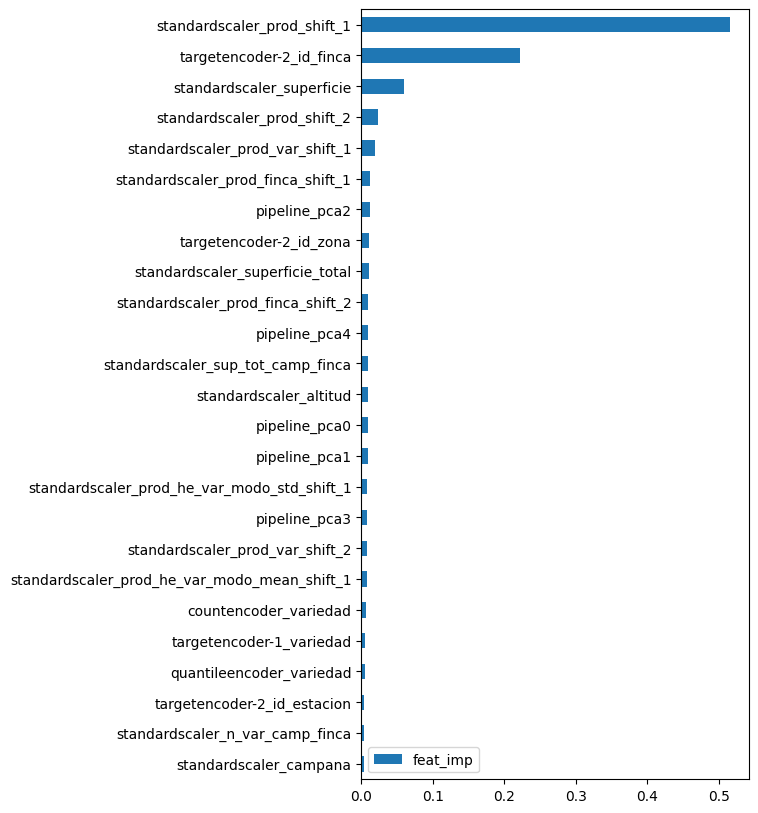

In [164]:
pd.DataFrame(
    rf.feature_importances_,
    index=fno,
    columns=['feat_imp']
).sort_values('feat_imp', ascending=True)[-30:].plot(kind='barh', figsize=(5,10))

<Axes: >

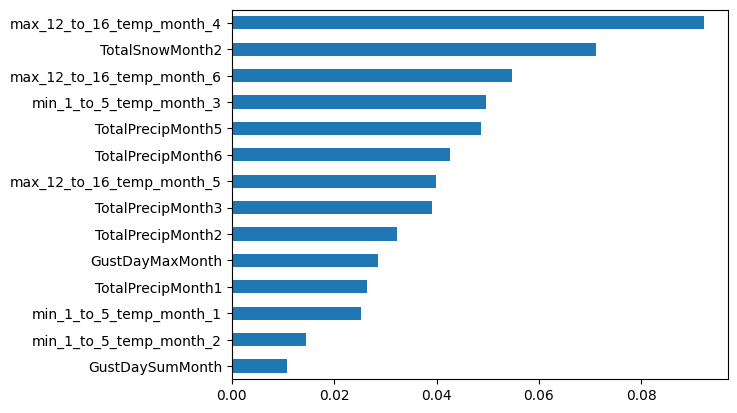

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

pd.concat([X[eto_cols+meteo_cols],y],axis=1).corr().abs().iloc[:,-1].dropna().sort_values()[-15:-1].plot(kind='barh')

/Users/vito/Documents/Projects/python/datathon-cajamar-malbecs/venv/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


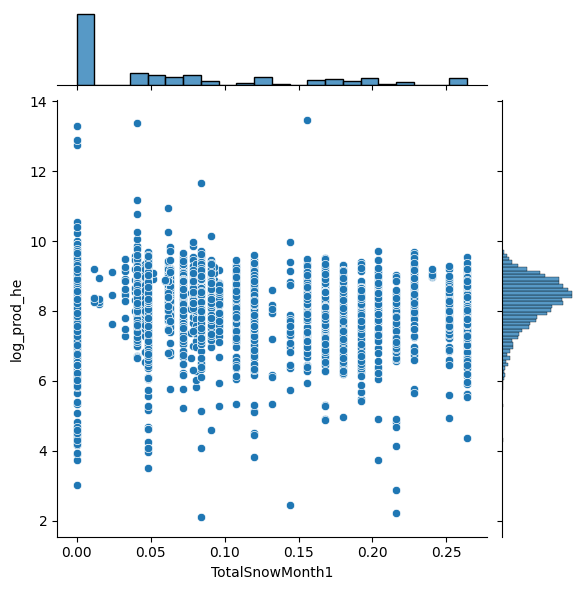

In [51]:
weather_data = pd.concat([X[eto_cols+meteo_cols+['superficie']],y],axis=1)

sns.jointplot(
    weather_data.assign(log_prod_he=lambda df: np.log(1+(df['produccion']/df['superficie']))),
    x='TotalSnowMonth1',
    y="log_prod_he"
)

In [148]:
import shap
shap.initjs()

In [149]:
explainer = shap.TreeExplainer(rf)

X_sampled = X.sample(1000)

shap_values = explainer.shap_values(X_sampled)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X_sampled.iloc[0,:])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


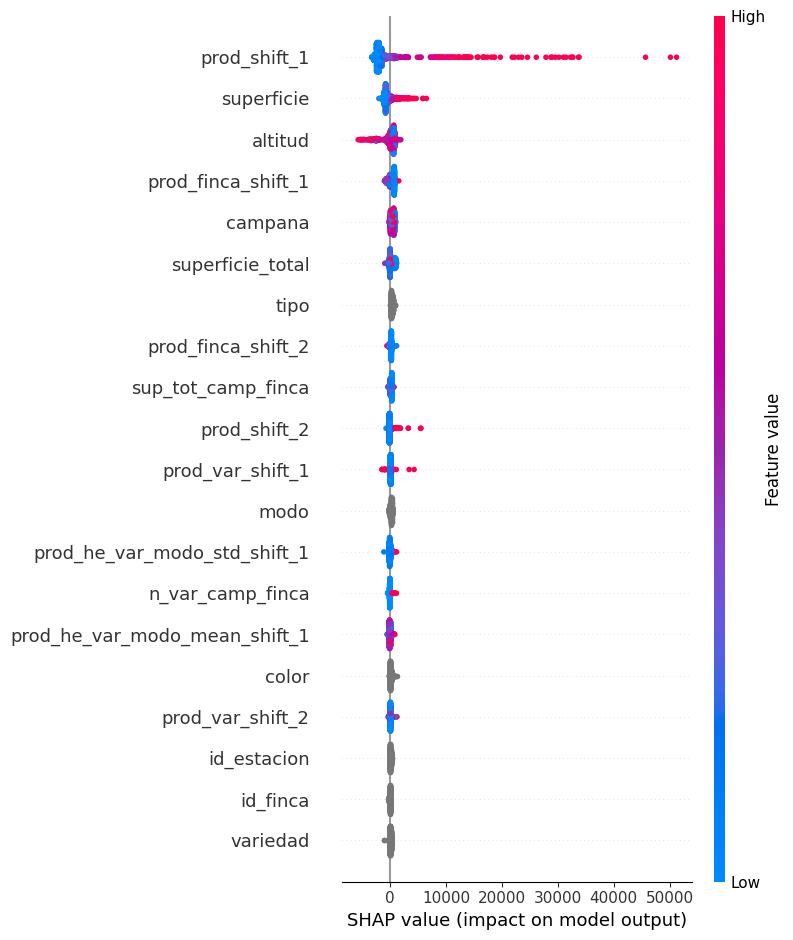

In [150]:
shap.summary_plot(shap_values, X_sampled)

In [419]:
# https://www.statsmodels.org/dev/generated/statsmodels.regression.mixed_linear_model.MixedLM.html

glmenc = ce.GLMMEncoder()
finca_trans = glmenc.fit_transform(X[['id_finca']], y)

x = X[['id_finca']] 
x['id_finca_enc']=finca_trans



## Hyperparameters Search

In [51]:
from sklearn.model_selection._split import _BaseKFold
from sklearn.utils.validation import _num_samples
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


class YearKFold(_BaseKFold):
    def __init__(self, test_idxs):
        self.test_idxs = test_idxs
        self.n_splits = len(test_idxs)

    def _iter_test_indices(self, X:pd.DataFrame, y=None, groups=None):
        for idx in self.test_idxs:
            yield idx


In [75]:
test_idxs = []
for i in range(19, 22):
    test_idxs.append(X['campana'] == i)


def rmse_scorer(m, X, y):
    return np.mean(rmse_score(y, m.predict(X)))


cv = YearKFold(test_idxs)


In [87]:



id_cols = [
    'id_finca',
    'id_zona',
    'id_estacion'
]

ord_cols = [
    'modo',
    'tipo',
    'color'
]

rest_cat_cols = [
    'variedad'
]

prep = make_column_transformer(
    # (ce.CountEncoder(), rest_cat_cols),
    # (ce.QuantileEncoder(), rest_cat_cols),
    (ce.TargetEncoder(), rest_cat_cols),

    # (ce.GLMMEncoder(), id_cols),
    (ce.TargetEncoder(), id_cols),

    # (make_pipeline(StandardScaler(), PCA(n_components=5)), meteo_cols+eto_cols),

    (StandardScaler(), wine_num_cols),
    # remainder='passthrough'
    remainder='drop'
)

m = make_pipeline(
    prep,
    CatBoostRegressor(random_state=seed, verbose=0)
    # XGBRegressor(random_state=seed, n_jobs=-1)
    # RandomForestRegressor(random_state=seed, n_jobs=-1)
)

final_cols = wine_num_cols+id_cols+rest_cat_cols+meteo_cols+eto_cols+ord_cols
# final_cols = wine_num_cols+id_cols+rest_cat_cols+ord_cols

param_grid = {
    # "randomforestregressor__n_estimators":[100,200,300],
    # "randomforestregressor__max_depth": [5,6,7,8]
    "catboostregressor__iterations": [100, 200, 300, 500],
    "catboostregressor__max_depth": [4, 6, 8,12]
}

gsm = GridSearchCV(
    m,
    param_grid=param_grid,
    cv=cv,
    scoring=rmse_scorer,
    n_jobs=-1
)

gsm.fit(X,y)



/Users/vito/Documents/Projects/python/datathon-cajamar-malbecs/venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=YearKFold(test_idxs=[0       False
1       False
2       False
3       False
4       False
        ...
8477    False
8478    False
8479    False
8480    False
8481    False
Name: campana, Length: 8482, dtype: bool, 0       False
1       False
2       False
3       False
4       False
        ...
8477    F...ue
8478     True
8479     True
8480     True
8481     True
Name: campana, Length: 8482, dtype: bool]),
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('targe...
                                                                          'prod_var_shift_2',
                                                                          'prod_finca_shift_1',
                                                                          'prod_finca_shift_2',
                                                                          'prod_he_var_modo_mean_shift_1',
                                                                          'prod_he_var_modo_std_shift_1'])])),
                                       ('catboostregressor',
                                        <catboost.core.CatBoostRegressor object at 0x16fa86820>)]),
             n_jobs=-1,
             param_grid={'catboostregressor__iterations': [100, 200, 300, 500],
                         'catboostregressor__max_depth': [4, 6, 8, 12]},
             scoring=<function rmse_scorer at 0x16fa7df70>)

In [89]:
gsm.best_params_

{'catboostregressor__iterations': 100, 'catboostregressor__max_depth': 8}

In [93]:
cross_validate(
    estimator=gsm.best_estimator_,
    X=X,
    y=y,
    cv=cv,
    n_jobs=-1,
    scoring=rmse_scorer,
    return_train_score=True
)


{'fit_time': array([0.60651231, 0.53535795, 0.53968692]),
 'score_time': array([0.00643468, 0.00633097, 0.00540781]),
 'test_score': array([5872.16170641, 7005.39654604, 5965.29071797]),
 'train_score': array([2472.62852682, 2345.7871801 , 2453.02501487])}